Parameters study

Train#=70000 Test#=30000
Labels=[1. 0.]
MLP best for 250 iterations (lr_type=constant and lr=0.5


<Figure size 600x450 with 0 Axes>

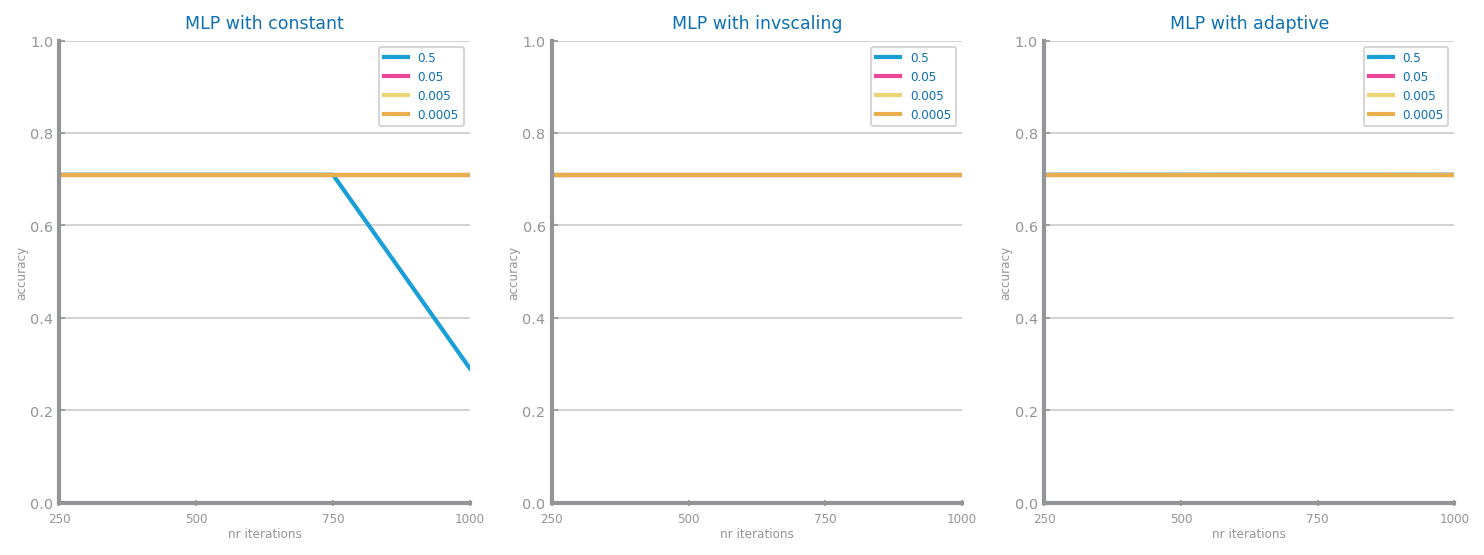

In [10]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.neural_network import MLPClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart
from dslabs_functions import get_variable_types
from seaborn import heatmap
from dslabs_functions import HEIGHT, plot_multi_scatters_chart
from matplotlib.pyplot import figure, subplots, savefig, show, gcf
from dslabs_functions import plot_bar_chart
from dslabs_functions import set_chart_labels
from dslabs_functions import define_grid, HEIGHT
from matplotlib.figure import Figure
from numpy import ndarray
from dslabs_functions import *
from pandas import read_csv, DataFrame
from numpy import log
from pandas import Series
from scipy.stats import norm, expon, lognorm
from matplotlib.axes import Axes
from dslabs_functions import plot_multiline_chart
import pandas as pd
from sklearn.model_selection import train_test_split

def mlp_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[MLPClassifier | None, dict]:
    nr_iterations: list[int] = [lag] + [
        i for i in range(2 * lag, nr_max_iterations + 1, lag)
    ]

    lr_types: list[Literal["constant", "invscaling", "adaptive"]] = [
        "constant",
        "invscaling",
        "adaptive",
    ]  # only used if optimizer='sgd'
    learning_rates: list[float] = [0.5, 0.05, 0.005, 0.0005]

    best_model: MLPClassifier | None = None
    best_params: dict = {"name": "MLP", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    _, axs = subplots(
        1, len(lr_types), figsize=(len(lr_types) * HEIGHT, HEIGHT), squeeze=False
    )
    for i in range(len(lr_types)):
        type: str = lr_types[i]
        values = {}
        for lr in learning_rates:
            warm_start: bool = False
            y_tst_values: list[float] = []
            for j in range(len(nr_iterations)):
                clf = MLPClassifier(
                    learning_rate=type,
                    learning_rate_init=lr,
                    max_iter=lag,
                    warm_start=warm_start,
                    activation="logistic",
                    solver="sgd",
                    verbose=False,
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                warm_start = True
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (type, lr, nr_iterations[j])
                    best_model = clf
                # print(f'MLP lr_type={type} lr={lr} n={nr_iterations[j]}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            nr_iterations,
            values,
            ax=axs[0, i],
            title=f"MLP with {type}",
            xlabel="nr iterations",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'MLP best for {best_params["params"][2]} iterations (lr_type={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params



# UNCOMMENT IF BALANCING IS APPLIED:
# data_to_split = read_csv('csv-results/credit-score-before-balancing')

results = "csv-results/credit-score-after-preparation.csv"
file_tag = "credit_score"
data: DataFrame = read_csv(results, index_col="ID")
data_to_split = data.copy()

# Split train/test


target = 'Credit_Score'
y = data_to_split[target]
X = data_to_split.drop(columns = target)
trnX, tstX, trnY, tstY = train_test_split(X, y, test_size=0.3)
train = pd.concat([trnX, trnY], axis=1)
test = pd.concat([tstX, tstY], axis=1)

labels = data.Credit_Score.unique()

vars = data.columns.to_list()
vars.remove('Credit_Score')


eval_metric = "accuracy"

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"images/{file_tag}_mlp_{eval_metric}_study.png")
show()

Best Model performance

<Figure size 600x450 with 0 Axes>

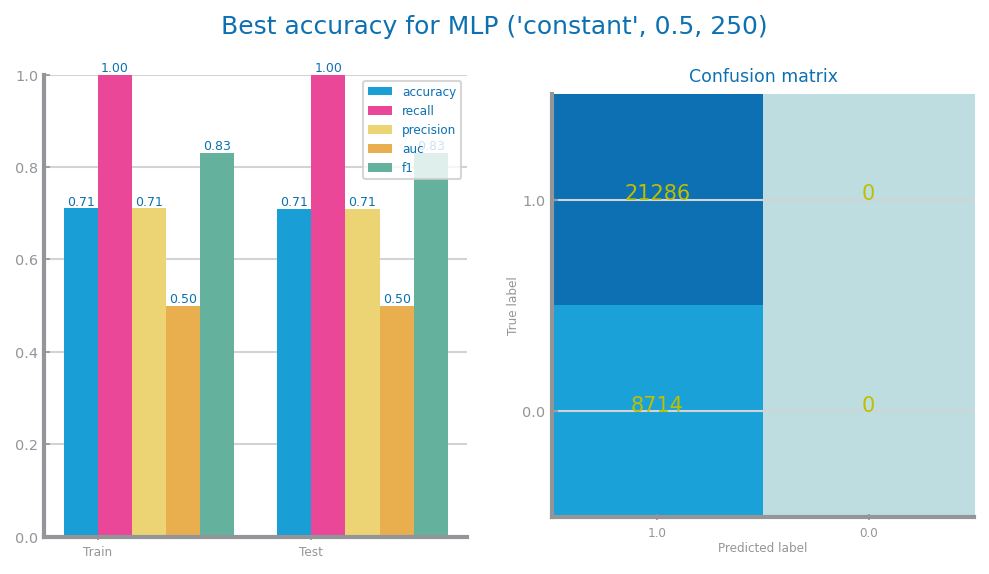

In [11]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_mlp_{params["name"]}_best_{params["metric"]}_eval.png')
show()

Overfitting study

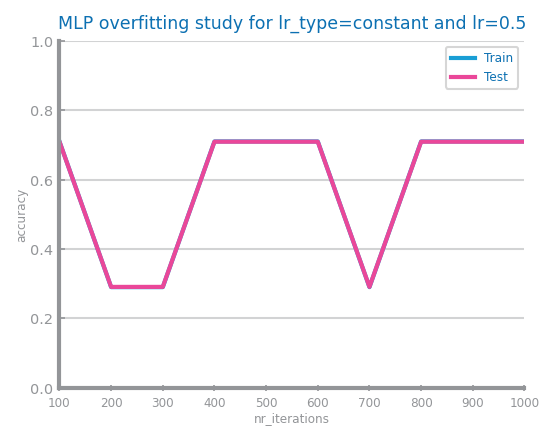

In [12]:
lr_type: Literal["constant", "invscaling", "adaptive"] = params["params"][0]
lr: float = params["params"][1]
nr_iterations: list[int] = [i for i in range(100, 1001, 100)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"

warm_start: bool = False
for n in nr_iterations:
    clf = MLPClassifier(
        warm_start=warm_start,
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="sgd",
        verbose=False,
    )
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_mlp_{eval_metric}_overfitting.png")